In [1]:
from google.colab import files
files.upload()   # Choose kaggle.json when prompted


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"niggasus","key":"c463e00753eb3ea16573446cb0bfc9ef"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [3]:
!kaggle datasets download -d jtiptj/chest-xray-pneumoniacovid19tuberculosis


Dataset URL: https://www.kaggle.com/datasets/jtiptj/chest-xray-pneumoniacovid19tuberculosis
License(s): other
 99% 1.72G/1.74G [00:12<00:00, 142MB/s]
100% 1.74G/1.74G [00:12<00:00, 154MB/s]


In [4]:
import zipfile
import os

# unzip the dataset
zip_path = "/content/chest-xray-pneumoniacovid19tuberculosis.zip"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content/chest_xray")

# check extracted folders
os.listdir("/content/chest_xray")


['test', 'train', 'val']

In [5]:
import warnings
warnings.filterwarnings("ignore")

# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import (
    Flatten, Dense, GlobalAveragePooling2D, Dropout, BatchNormalization,
    Input, Add, Concatenate, PReLU, LayerNormalization, Conv2D, MaxPooling2D
)
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import DenseNet121, EfficientNetB4, VGG16, ResNet152
from tensorflow.keras.regularizers import l2

# Other libraries
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import os
import cv2


In [6]:
tf.random.set_seed(42)
np.random.seed(42)

# Image properties and directories
IMG_SHAPE = (200, 200)
TRAIN_DIR = '/content/chest_xray/train'
VAL_DIR = '/content/chest_xray/val'
TEST_DIR = '/content/chest_xray/test'
BATCH_SIZE = 16

In [28]:
train_val_gen = ImageDataGenerator(validation_split=0.2, preprocessing_function=preprocess_input)
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_data = train_val_gen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    subset='training'
)

val_data = train_val_gen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    subset='validation'
)

test_data = test_gen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 5061 images belonging to 4 classes.
Found 6 images belonging to 4 classes.
Found 771 images belonging to 4 classes.


In [29]:
class_labels = list(train_data.class_indices.keys())
print(f"Detected Classes: {class_labels}")

Detected Classes: ['COVID19', 'NORMAL', 'PNEUMONIA', 'TURBERCULOSIS']


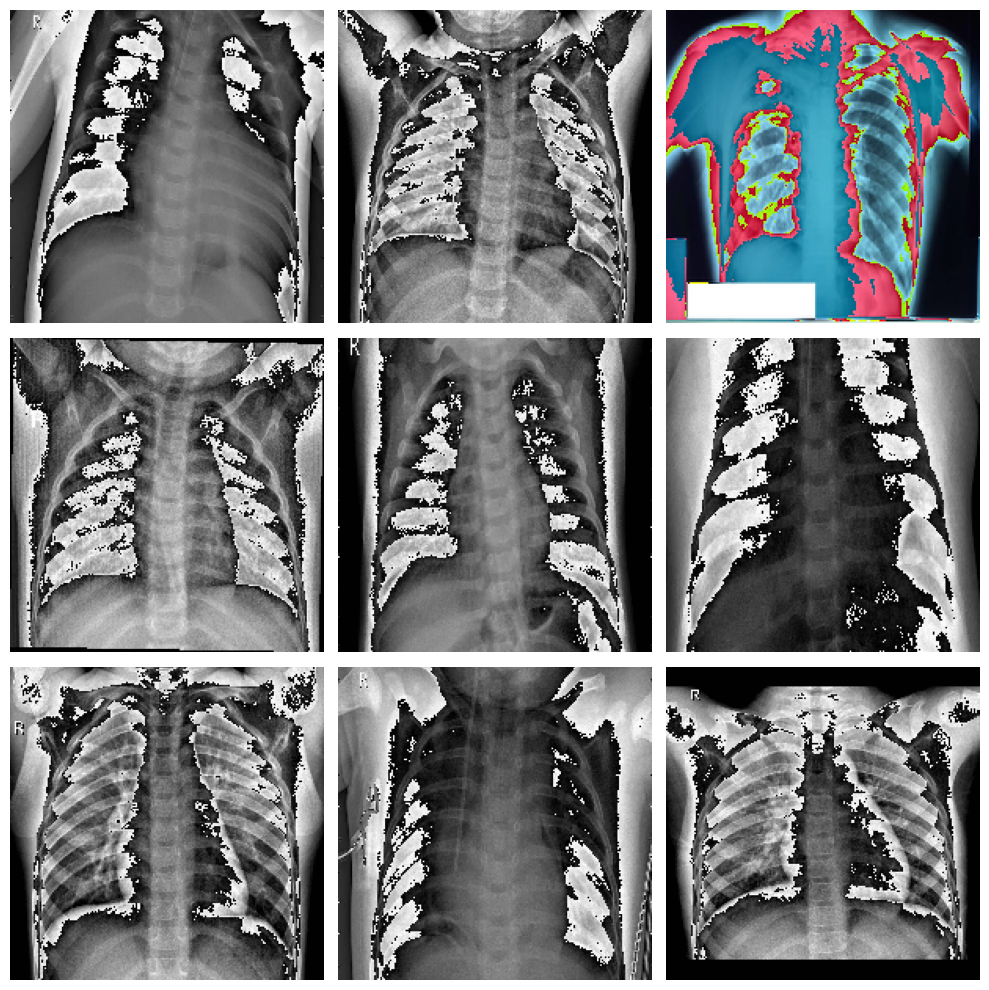

In [30]:
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    sample_img = next(train_data)[0][0] * 255
    plt.imshow(sample_img.astype('uint8'))
    plt.axis('off')
plt.tight_layout()
plt.show()

In [31]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(200, 200, 3))

In [32]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
output_layer = Dense(4, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output_layer)

In [33]:
for layer in base_model.layers:
    layer.trainable = False

In [34]:
optimizer = AdamW(learning_rate=0.001, weight_decay=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [35]:
callbacks = [
    ModelCheckpoint(filepath='best_model_densenet.keras', monitor='val_loss', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, verbose=1)
]

In [36]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    callbacks=callbacks,
    steps_per_epoch=train_data.samples // BATCH_SIZE,
    validation_steps=val_data.samples // BATCH_SIZE
)

Epoch 1/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.8544 - loss: 0.3791
Epoch 1: val_loss improved from inf to 0.27601, saving model to best_model_densenet.keras
316/316 ━━━━━━━━━━━━━━━━━━━━ 104s 260ms/step - accuracy: 0.8546 - loss: 0.3786 - val_accuracy: 0.8333 - val_loss: 0.2760
Epoch 2/10
  1/316 ━━━━━━━━━━━━━━━━━━━━ 17s 56ms/step - accuracy: 0.9375 - loss: 0.2078
Epoch 2: val_loss improved from 0.27601 to 0.21644, saving model to best_model_densenet.keras
316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9375 - loss: 0.2078 - val_accuracy: 0.8333 - val_loss: 0.2164
Epoch 3/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.9606 - loss: 0.1166
Epoch 3: val_loss improved from 0.21644 to 0.16167, saving model to best_model_densenet.keras
316/316 ━━━━━━━━━━━━━━━━━━━━ 104s 176ms/step - accuracy: 0.9605 - loss: 0.1167 - val_accuracy: 0.8333 - val_loss: 0.1617
Epoch 4/10
  1/316 ━━━━━━━━━━━━━━━━━━━━ 16s 51ms/step - accuracy: 1.0000 - loss: 0.0488
Epoch 4: va

In [37]:
val_loss, val_acc = model.evaluate(val_data)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_acc}")

test_loss, test_acc = model.evaluate(test_data)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 0.0193
Validation Loss: 0.019298560917377472, Validation Accuracy: 1.0
49/49 ━━━━━━━━━━━━━━━━━━━━ 26s 330ms/step - accuracy: 0.8819 - loss: 0.3212
Test Loss: 0.3005712628364563, Test Accuracy: 0.8910505771636963


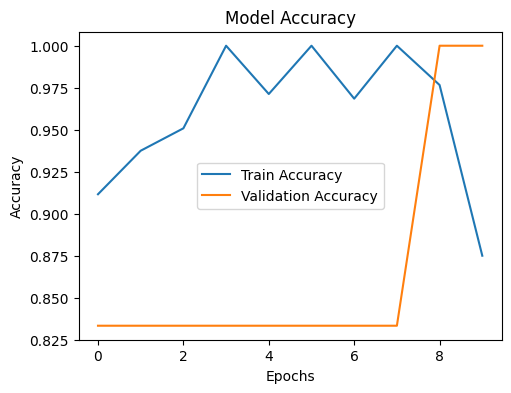

In [38]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

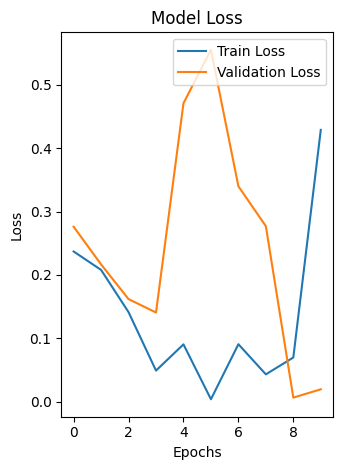

In [39]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [40]:
y_pred = model.predict(test_data, verbose=1)
y_pred_classes = np.argmax(y_pred,axis=1)

49/49 ━━━━━━━━━━━━━━━━━━━━ 32s 387ms/step


In [41]:
print("Classification Report:")
print(classification_report(test_data.classes, y_pred_classes, target_names=class_labels))

Classification Report:
               precision    recall  f1-score   support

      COVID19       0.96      0.93      0.95       106
       NORMAL       0.88      0.79      0.83       234
    PNEUMONIA       0.88      0.94      0.91       390
TURBERCULOSIS       0.89      0.95      0.92        41

     accuracy                           0.89       771
    macro avg       0.90      0.90      0.90       771
 weighted avg       0.89      0.89      0.89       771



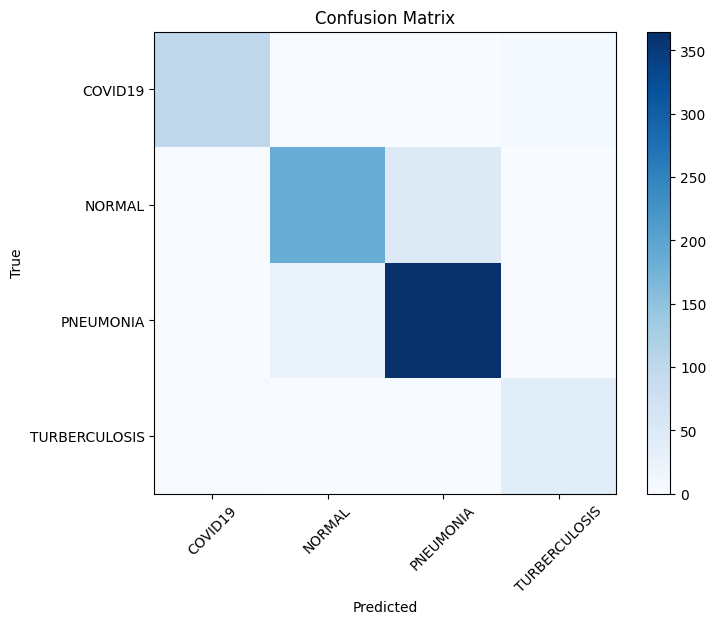

In [42]:
conf_matrix = confusion_matrix(test_data.classes, y_pred_classes)
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks(ticks=np.arange(len(class_labels)), labels=class_labels, rotation=45)
plt.yticks(ticks=np.arange(len(class_labels)), labels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Model saved to disk.


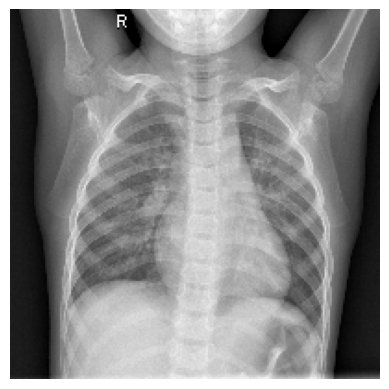

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
Predicted Class: NORMAL


In [43]:
model.save("lungs_classification_model_densenet.h5")
print("Model saved to disk.")

# Prediction function
def predict_image(model_path, image_path, class_labels):
    # Load the pre-trained model
    model = load_model("lungs_classification_model_densenet.h5")
 # Load and preprocess the image
    img = image.load_img(image_path, target_size=(200, 200))
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0  # Normalize pixel values to [0, 1]

    # Display the image
    plt.imshow(np.array(img).astype('uint8'))
    plt.axis('off')
    plt.show()
    # Predict the class
    prediction = model.predict(img_array.reshape(1, 200, 200, 3))
    class_index = np.argmax(prediction)
    print(f"Predicted Class: {class_labels[class_index]}")

# Test the prediction function
predict_image("lungs_classification_model_densenet.h5", "/content/chest_xray/train/NORMAL/IM-0115-0001.jpeg", class_labels)

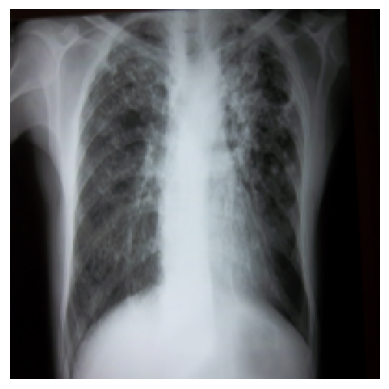

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
Predicted Class: TURBERCULOSIS


In [44]:

# Prediction function
def predict_image(model_path, image_path, class_labels):
    # Load the pre-trained model
    model = load_model("lungs_classification_model_densenet.h5")
 # Load and preprocess the image
    img = image.load_img(image_path, target_size=(200, 200))
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0  # Normalize pixel values to [0, 1]

    # Display the image
    plt.imshow(np.array(img).astype('uint8'))
    plt.axis('off')
    plt.show()
    # Predict the class
    prediction = model.predict(img_array.reshape(1, 200, 200, 3))
    class_index = np.argmax(prediction)
    print(f"Predicted Class: {class_labels[class_index]}")

# Test the prediction function
predict_image("lungs_classification_model_densenet.h5", "/content/chest_xray/test/TURBERCULOSIS/Tuberculosis-700.png", class_labels)